## The purpose of this notebook is to evaluate mass balance results.
I first focus on evaporation and compare our results to the theoretical results.  The comparison shows that our diesel evaporation is wrong.  My guess is that it's the way the time stepping is handled in the calculation of evaporation using the SquareRoot equation. To test this hypothesis, I ran the Bunker-C case using a Fingas evaporation relationship that is proportional to the square root of time rather than the natural log.  The Bunker-C results confirm that the first time step of the SquareRoot option needs to be fixed.  The problem with the diesel case isn't related to other parameter choices in the diesel case. 

In addition to testing mass balance, I also play around with plotting strategies and the use of a color dictionary.  I like the color dictionary approach but need to learn how to scale it for many runs. 

In [1]:
import sys
sys.path.insert(1, '/Users/rmueller/Projects/MIDOSS/analysis-rachael/scripts/')

from midoss_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

### Define color dictionary to use in plotting

In [2]:
color_dict = {"MOHID bunker-C": "darkolivegreen", "MOHID diesel": "indigo", 
             "Bunker_C_MassEvap": "yellowgreen", 
              "Bunker-C (short-term)": "black",  "Bunker-C (long-term)": "grey",
              "Bunker-C (Anchorage, short-term)": "darkolivegreen", 'Bunker-C (Anchorage, long-term)':"yellowgreen",
             "Diesel_MassEvap": "mediumpurple", "Diesel": "mediumpurple",
             "AKNS": "sienna", "MOHID-old akns": "saddlebrown", "Akns_MassEvap":"sienna",
             "MOHID-old diesel": "darkmagenta", 
             "MOHID-old bunker-C": "olivedrab"}

### Define analytical evaporation rates

Text(0.5, 0, 'time [days]')

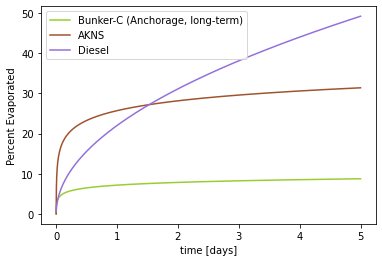

In [3]:
days = 5
time_in_minutes = [np.float(x) for x in range(1,60*24*days,1)]
time_in_days = [
    minutes/(60*24) for minutes in time_in_minutes
    ]
SST = 15

evaporation = {'time':time_in_days, 
      'Bunker-C (short-term)':(0.35 + 0.13 * SST) * np.sqrt(time_in_minutes), 
      'Bunker-C (long-term)':(-0.21 + 0.045 * SST) * np.log(time_in_minutes),          
      'Bunker-C (Anchorage, short-term)':(-0.13 + 0.013 * SST) * np.sqrt(time_in_minutes),
      'Bunker-C (Anchorage, long-term)':(0.31 + 0.045 * SST) * np.log(time_in_minutes),
      'AKNS': (2.86 + 0.045 * SST) * np.log(time_in_minutes),
      'Diesel': (0.31 + 0.018 * SST) * np.sqrt(time_in_minutes)
     } 
  
# Create DataFrame 
evaporation_df = pd.DataFrame(evaporation)
evaporation_df = evaporation_df.set_index('time')

# plot evaporation rates
cols_plot = ['Bunker-C (Anchorage, long-term)', 'AKNS', 'Diesel']
ax = evaporation_df[cols_plot].plot(
    linewidth=1.5,
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Percent Evaporated')
ax.set_xlabel('time [days]')

### Plot all bunker-c
Note: These are for temperatures of 15C.  Bunker-C (Anchorage, short-term) will be less than zero and set to zero for all temperatures lower than 10C.  

(0.0, 50.0)

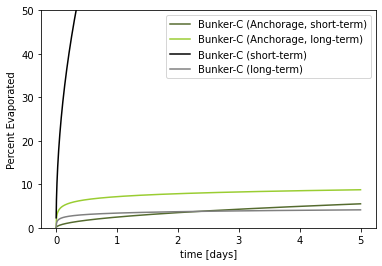

In [4]:
# plot evaporation rates
cols_plot = ['Bunker-C (Anchorage, short-term)','Bunker-C (Anchorage, long-term)', 'Bunker-C (short-term)', 'Bunker-C (long-term)']
ax = evaporation_df[cols_plot].plot(
    linewidth=1.5,
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Percent Evaporated')
ax.set_xlabel('time [days]')
ax.set_ylim(0,50)

For review: 
-      'Bunker-C (Anchorage, short-term)':(-0.13 + 0.013 * SST) * np.sqrt(time_in_minutes),
-      'Bunker-C (Anchorage, long-term)':(0.31 + 0.045 * SST) * np.log(time_in_minutes),
-      'Bunker-C (short-term)':(0.35 + 0.13 * SST) * np.sqrt(time_in_minutes), 
-      'Bunker-C (long-term)':(-0.21 + 0.045 * SST) * np.log(time_in_minutes),          

### Load MOHID output

In [5]:
results_path = Path('/Users/rmueller/Projects/MIDOSS/results')
bunker_sro = results_path/'SoG_10000_bunkerc'/'resOilOutput.sro'
diesel_sro = results_path/'SoG_10000_diesel'/'resOilOutput.sro'
bunker_old_sro = results_path/'SusanResults'/'Lagrangian_SoG_10000_SoG_10000_bunkerc.sro'
akns_old_sro   = results_path/'SusanResults'/'Lagrangian_SoG_10000_SoG_10000_AKNS.sro'
diesel_old_sro = results_path/'SusanResults'/'Lagrangian_SoG_10000_SoG_10000_diesel.sro'

# load new mass balance
bunker_data = load_sro(bunker_sro,["MEvaporated"])
diesel_data = load_sro(diesel_sro,["MEvaporated"])
# load old mass balance
bunker_data_old = load_sro(bunker_old_sro,["MEvaporated"])
diesel_data_old = load_sro(diesel_old_sro,["MEvaporated"])
akns_data_old = load_sro(akns_old_sro,["MEvaporated"])

/Users/rmueller/Projects/MIDOSS/analysis-rachael/scripts/midoss_utils.py:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pandas.datetime(numpy.int(YY), numpy.int(MM), numpy.int(DD),
/Users/rmueller/Projects/MIDOSS/analysis-rachael/scripts/midoss_utils.py:65: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pandas.datetime(numpy.int(YY), numpy.int(MM), numpy.int(DD),


### Rename columns

In [6]:
# First: 
bunker_data.rename(columns={"MEvaporated": "MOHID bunker-C"}, inplace=True)
diesel_data.rename(columns={"MEvaporated": "MOHID diesel"}, inplace=True)
bunker_data_old.rename(columns={"MEvaporated": "MOHID-old bunker-C"}, inplace=True)
diesel_data_old.rename(columns={"MEvaporated": "MOHID-old diesel"}, inplace=True)
akns_data_old.rename(columns={"MEvaporated": "MOHID-old akns"}, inplace=True)

# concat evaporation rates for MOHID output only
frames = [bunker_data, diesel_data, bunker_data_old, diesel_data_old, akns_data_old]
mohid_evap = pd.concat(frames, sort=True)

In [7]:
spill_volume = 100000
# convert percent evaporated to mass 
#all_evap["Bunker-C (Anchorage-long term)"] = numpy.zeros(len(evaporation_df["Bunker-C (Anchorage-long term)"]))
evaporation_df["Bunker_C_MassEvap"] = [
    percent*spill_volume for percent in evaporation_df["Bunker-C (Anchorage-long term)"]
]
evaporation_df["Diesel_MassEvap"] = [
    percent*spill_volume for percent in evaporation_df["Diesel"]
]
evaporation_df["Akns_MassEvap"] = [
    percent*spill_volume for percent in evaporation_df["AKNS"]
]
evaporation_df.columns

KeyError: 'Bunker-C (Anchorage-long term)'

### Plot MOHID results, both old and new

In [ ]:
cols_plot = ["MOHID bunker-C", "MOHID diesel", "MOHID-old bunker-C", "MOHID-old diesel", "MOHID-old akns"]
ax = mohid_evap[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Evaporated')
ax.set_xlabel('time [days]')

### plot comparison of MOHID output and theoretical evaporation curves

In [ ]:
cols_plot = ["MOHID bunker-C", "MOHID diesel", "MOHID-old akns"]
ax = mohid_evap[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name, '#333333') for column_name in cols_plot]
)
cols_plot = ["Bunker_C_MassEvap", "Diesel_MassEvap", "Akns_MassEvap"]
evaporation_df[cols_plot].plot(
    ax = ax,
    linewidth=1.5,
    color = [color_dict.get(column_name, '#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Evaporated')
ax.set_xlabel('time [days]')
ax.set_xlim(0,4)

In [ ]:
cols_plot = "MOHID diesel"
ax = mohid_evap[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(cols_plot, '#333333')]
)
cols_plot = "Diesel_MassEvap"
evaporation_df[cols_plot].plot(
    ax = ax,
    linewidth=1.5,
    color = [color_dict.get(cols_plot, '#333333')]
)
ax.set_ylabel('Mass Evaporated')
ax.set_xlabel('time [days]')
ax.set_xlim(0,4)

### Evaluate all mass 

In [ ]:
load_sro(bunker_sro,'list')

In [ ]:
bunker_data = load_sro(bunker_sro, ["MEvaporated","MDispersed","MDissolved","MBio"])
diesel_data = load_sro(diesel_sro,["MEvaporated","MDispersed","MDissolved","MBio"])
bunker_data_old = load_sro(bunker_old_sro,["MEvaporated","MDispersed","MDissolved","MBio"])
diesel_data_old = load_sro(diesel_old_sro,["MEvaporated","MDispersed","MDissolved","MBio"])

# rename columns
bunker_data.rename(columns={"MEvaporated": "Bunker-C Evaporation (new)",
                           "MDispersed": "Bunker-C Dispersed (new)",
                           "MDissolved": "Bunker-C Dissolved (new)",
                           "MBio": "Bunker-C Biodegraded (new)"}, 
                   inplace=True
                  )
diesel_data.rename(columns={"MEvaporated": "Diesel Evaporation (new)",
                           "MDispersed": "Diesel Dispersed (new)",
                           "MDissolved": "Diesel Dissolved (new)",
                           "MBio": "Diesel Biodegraded (new)"}, 
                   inplace=True
                  )
bunker_data_old.rename(columns={"MEvaporated": "Bunker-C Evaporation (old)",
                           "MDispersed":"Bunker-C Dispersed (old)",
                           "MDissolved":"Bunker-C Dissolved (old)",
                           "MBio":"Bunker-C Biodegraded (old)"}, 
                       inplace=True
                      )
diesel_data_old.rename(columns={"MEvaporated": "Diesel Evaporation (old)",
                           "MDispersed": "Diesel Dispersed (old)",
                           "MDissolved": "Diesel Dissolved (old)",
                           "MBio": "Diesel Biodegraded (old)"}, 
                       inplace=True
                      )

# concat evaporation rates for MOHID output only
frames = [bunker_data, diesel_data, bunker_data_old, diesel_data_old]
mohid_massbalance = pd.concat(frames, sort=True)

color_dict = {"Bunker-C Evaporation (new)": "darkolivegreen", "Bunker-C Evaporation (old)": "olivedrab", "Bunker-C (bad)": "olive", 
              "Bunker-C Dispersed (new)": "royalblue","Bunker-C Dispersed (old)": "cornflowerblue",
              "Bunker-C Dissolved (new)": "saddlebrown", "Bunker-C Dissolved (old)": "chocolate",
              "Bunker-C Biodegraded (new)": "black", "Bunker-C Biodegraded (old)": "grey",
              "Diesel Evaporation (new)": "indigo", "Diesel Evaporation (old)": "mediumpurple",
              "Diesel Dispersed (new)": "steelblue","Diesel Dispersed (old)": "lightblue",
              "Diesel Dissolved (new)": "maroon", "Diesel Dissolved (old)": "brown",
              "Diesel Biodegraded (new)": "black", "Diesel Biodegraded (old)": "grey"
             }

In [ ]:
evaporated_cols = ["Bunker-C Evaporation (new)", "Diesel Evaporation (new)", "Bunker-C Evaporation (old)", "Diesel Evaporation (old)"]
dispersed_cols = ["Bunker-C Dispersed (new)", "Diesel Dispersed (new)", "Bunker-C Dispersed (old)", "Diesel Dispersed (old)"]
dissolved_cols = ["Bunker-C Dissolved (new)","Diesel Dissolved (new)","Bunker-C Dissolved (old)","Diesel Dissolved (old)"]
bio_cols = ["Bunker-C Biodegraded (new)","Diesel Biodegraded (new)","Bunker-C Biodegraded (old)","Diesel Biodegraded (old)"]

In [ ]:
# Evaporation
cols_plot = evaporated_cols
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Evaporated')
ax.set_xlabel('time [days]')

# Dispersion
cols_plot = dispersed_cols
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Dispersed')
ax.set_xlabel('time [days]')

# Dissolution
cols_plot = dissolved_cols
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Dissolved')
ax.set_xlabel('time [days]')

# Biodegredation
cols_plot = bio_cols
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Biodegraded')
ax.set_xlabel('time [days]')

### Old values of diesel definitely looked wonky.  Re-doing graphics for new values only

In [ ]:
dispersed_cols = ["Bunker-C Dispersed (new)", "Diesel Dispersed (new)"]
dissolved_cols = ["Bunker-C Dissolved (new)","Diesel Dissolved (new)"]


# Dispersion
cols_plot = ["Bunker-C Dispersed (new)", "Diesel Dispersed (new)"]
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Dispersed')
ax.set_xlabel('time [days]')

# Dissolution
cols_plot = dissolved_cols
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='x',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass Dissolved')
ax.set_xlabel('time [days]')

### New bunker

In [ ]:
new_bunker = ["Bunker-C Evaporation (new)", "Bunker-C Dispersed (new)","Bunker-C Dissolved (new)","Bunker-C Biodegraded (new)"]
old_bunker = ["Bunker-C Evaporation (old)", "Bunker-C Dispersed (old)", "Bunker-C Dissolved (old)","Bunker-C Biodegraded (old)"]
new_diesel = ["Diesel Evaporation (new)", "Diesel Dispersed (new)",  "Diesel Dissolved (new)","Diesel Biodegraded (new)"]
old_diesel = ["Diesel Evaporation (old)","Diesel Dispersed (old)","Diesel Dissolved (old)","Diesel Biodegraded (old)"]

In [ ]:
cols_plot = new_bunker
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass')
ax.set_xlabel('time [days]')

cols_plot = old_bunker
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass')
ax.set_xlabel('time [days]')

cols_plot = new_diesel
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass')
ax.set_xlabel('time [days]')

cols_plot = old_diesel
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass')
ax.set_xlabel('time [days]')

In [ ]:
ax = mohid_massbalance[["Bunker-C Dispersed (new)", "Bunker-C Dispersed (old)"]].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Dispersed Mass')
ax.set_xlabel('time [days]')

## Evaluate results from test of Fingas Square Root parameterization using Bunker-C case

In [ ]:
badbunker_sro = results_path/'SoG_10000_bunkerc_bad'/'resOilOutput.sro'
badbunker_data = load_sro(badbunker_sro,["MEvaporated"])

cols_plot = "MEvaporated"
ax = badbunker_data[cols_plot].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass')
ax.set_xlabel('time [days]')


### Plot Mass Balance over time

In [ ]:
diesel_data.columns

In [ ]:
total_spill = 
mini_diesel =  diesel_data.loc[: , ['Diesel Evaporation (new)', 'Diesel Dispersed (new)','Diesel Dissolved (new)', 'Diesel Biodegraded (new)']]
diesel_data["total mass"] =  mini_diesel.sum(axis=1)

In [ ]:
cols_plot = [new_diesel,"total mass"]
ax = mohid_massbalance[cols_plot].plot(
    linewidth=1.5,
    marker='.',
    color = [color_dict.get(column_name,'#333333') for column_name in cols_plot]
)
ax.set_ylabel('Mass')
ax.set_xlabel('time [days]')

In [ ]:
cols_plot = [new_diesel,"total mass"]

In [ ]:
cols_plot

In [ ]:
load_sro(diesel_sro,'list')